In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn')
from collections import Counter

In [2]:
data_folder = 'data/'
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t')

/home/painguin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

### Chosen Fields

(at least some text that explains why we dropped the other fields)

In [3]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en', 'stores', 'countries_en',
                 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'carbon-footprint_100g', 'first_packaging_code_geo']

data = data[chosen_fields]

## Field Cleaning

The 'pnns_groups_1' field is particularly usefull in our study. 
Indeed, it sorts the different food entries by some clear category, as seen below.

A simple map allows for better organisation and also cleans the duplicate field entries:

In [4]:
my_map = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}

data['Category'] = data['pnns_groups_1'].replace(my_map)

Now the categories are clear:

In [5]:
data['Category'].value_counts()

Unknown              122881
Snacks                37054
Dairies               17948
Composite             14670
Starchy               14612
Fish Meat Eggs        13993
Fruits Vegetables     12632
Beverages             12411
Fat Sauces            11427
Name: Category, dtype: int64

From the 'main_category_en' field, we can recover more entries for the previous categories, as well as a new meaningfull category 'Plant-based foods and beverages', that we will rename 'Veggie' and add it as a new binary field in the data set.

In [6]:
data['main_category_en'].value_counts().head(20)

Plant-based foods and beverages    38524
Beverages                          26110
Sugary snacks                      25209
Dairies                            16145
Meats                               9801
Groceries                           9703
Meals                               8349
Spreads                             4629
Frozen foods                        3154
Fruit juices                        3108
Desserts                            3080
Salty snacks                        3008
Seafood                             2921
Canned foods                        2770
Fats                                1878
Baby foods                          1037
Sweeteners                           945
Sandwiches                           905
Farming products                     798
Fish and meat and eggs               741
Name: main_category_en, dtype: int64

First the usefull categories of `pnns_groups_1` and `main_category_en` are merged.
This merged categorical field is called `category`.

In [7]:
my_map_2 = {
    'Beverages' : 'Beverages',
    'Sugary snacks' : 'Snacks',
    'Dairies' : 'Dairies',
    'Meats' : 'Fish Meat Eggs',
    'Meals' : 'Composite',
    'Fruit juices' : 'Beverages',
    'Salty snacks' : 'Snacks',
    'Fats' : 'Fat Sauces',
    'Fish and meat and eggs' : 'Fish Meat Eggs'
}

In [8]:
not_in_category = data[data['Category'].isna()]
keys = my_map_2.keys()
not_in_category.query('main_category_en in @keys')['main_category_en'].value_counts()

Beverages                 5844
Meats                       68
Meals                       16
Fish and meat and eggs      12
Name: main_category_en, dtype: int64

We see that the number of usefull entries that are not already present in `pnns_group_1` are mainly from the `Beverages` category. Nonetheless, we build the new `Category` field as previously exposed, and add these categories, as well as the `pnns_group_1` fields.

In [9]:
# Adds the values in 'main_category_en' that are not in 'pnns_groups_1' after applying the map
new_vals = not_in_category.query('main_category_en in @keys')['main_category_en'].replace(my_map_2)
data.loc[new_vals.index, 'Category'] = new_vals

Here is the new 'Category' field.

In [10]:
data['Category'].value_counts()

Unknown              122881
Snacks                37054
Beverages             18255
Dairies               17948
Composite             14686
Starchy               14612
Fish Meat Eggs        14073
Fruits Vegetables     12632
Fat Sauces            11427
Name: Category, dtype: int64

Now the `Plant based food and beverages category` is used to create a new field called `Veggie`.

In [11]:
data['Veggie'] = data['main_category_en'] == 'Plant-based foods and beverages'

The veggie fields from `Category` are also added:

In [12]:
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Fruits Vegetables')
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Starchy')

In [13]:
data['Veggie'].value_counts()

False    658551
True      39926
Name: Veggie, dtype: int64

Notice that the `False` value doesn't mean that an entry is not veggie.

# Nutri-Score

The Nutri-Score system was developped after Article 14 of the Modernisation Law for the health system, dated 26 January 2016, required the french authorities to recommend a front-of-pack system of labelling that would be simple and accessible for all. 
The new system includes a colour coded scheme, ranging from green to orange, associated with letters from A to E. Productes designated with an 'A' have the best nutritional quality, while products designated with an E have poorer nutritional quality.

## Points A

| Points | Energy (kJ) | Fat (g) | Sugar (g) | Sodium (mg) |
|:------:|:-----------:|:-------:|:---------:|:-----------:|
|    0   |    <=335    |   <=1   |   <=4.5   |     <=90    |
|    1   |     >335    |    >1   |    >4.5   |     >90     |
|    2   |     >670    |    >2   |     >9    |     >180    |
|    3   |    >1005    |    >3   |   >13.5   |     >270    |
|    4   |    >1340    |    >4   |    >18    |     >360    |
|    5   |    >1675    |    >5   |   >22.5   |     >450    |
|    6   |    >2010    |    >6   |    >27    |     >540    |
|    7   |    >2345    |    >7   |    >31    |     >630    |
|    8   |    >2680    |    >8   |    >36    |     >720    |
|    9   |    >3015    |    >9   |    >40    |     >810    |
|   10   |    >3350    |   >10   |    >45    |     >900    |

## Points C

| Points | Fruits Vegetables Nuts (%) | Fiber (g) | Proteins (g) |
|:------:|:--------------------------:|:---------:|:------------:|
|    0   |            <=40            |   <=0.9   |     <=1.6    |
|    1   |             >40            |    >0.9   |     >1.6     |
|    2   |             >60            |    >1.9   |     >3.2     |
|    3   |              -             |    >2.8   |     >4.8     |
|    4   |              -             |    >3.7   |     >6.4     |
|    5   |             >80            |    >4.7   |     >8.0     |

## Nutri-Score Computation
  * If `points A` < 11, then `score` = `points A` - `points C`
  * If `points A` >= 11:
      * If `points(Fruits/Vegetables/Nuts)` = 5, then `score` = `points(A)` - `points(C)`
      * If `points(Fruits/Vegetables/Nuts)` < 5, then `score` = `points(A)` - (`points(Fiber)` + `points(Fruits/Vegetables/Nuts)`)

## Letters Thresholds
### Solid Food
  * A: until -1
  * B: from 0 to 2
  * C: from 3 to 10
  * D: from 11 to 18
  * E: 19 and more
  
### Beverages 
  * A: mineral and spring water
  * B: until 1
  * C: from 2 to 5
  * D: from 6 to 9
  * E: 10 and more

## Warning
When fiber content is not present, its eventual positive contribution is not taken into account.

Percentages corresponding to Fruits/Vegetables/Nuts are mainly missing from the packaging. 
It will be derived from other products as follows:
  * 100% : Fruit Juices
  * 90% : Fruit Compote
  * 85% : Vegetables
  * 50% : Jams
  
Tubers are not considered as vegetables for the nutri-score.

In [14]:
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
beverages = data.query('Category == "Beverages"')

#### Compute points A

In [16]:
# energy
energy_bins = [data['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data['energy_100g'].max()]
data['energy_points'] = pd.cut(data['energy_100g'], energy_bins, labels=range(11)).astype(float)

# energy for beverages
#bev_energy_bins = [beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, beverages['energy_100g'].max()]
#bev_energy_points = pd.cut(beverages['energy_100g'], bev_energy_bins, labels=range(11), include_lowest=True)
#data['energy_points'][bev_energy_points.index] = bev_energy_points

# fat
fat_bins = [data['fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data['fat_100g'].max()]
data['fat_points'] = pd.cut(data['fat_100g'], fat_bins, labels=range(11)).astype(float)

# sugar
sugar_bins = [data['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data['sugars_100g'].max()]
data['sugar_points'] = pd.cut(data['sugars_100g'], sugar_bins, labels=range(11)).astype(float)

# sugar for beverages
#bev_sugar_bins = [beverages['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, beverages['sugars_100g'].max()]
#bev_sugar_points = pd.cut(beverages['sugars_100g'], bev_sugar_bins, labels=range(11))
#data['sugar_points'][bev_sugar_points.index] = bev_sugar_points

# sodium
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
data['sodium_points'] = pd.cut(data['sodium_100g'], sodium_bins, labels=range(11)).astype(float)

data['points_A'] = data['energy_points'] + data['fat_points'] + data['sugar_points'] + data['sodium_points']

#### Compute points C

In [17]:
# fruits-vegetables-nuts
fvn_bins = [data['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data['fruits-vegetables-nuts_100g'].max()]
data['fvn_points'] = pd.cut(data['fruits-vegetables-nuts_100g'], fvn_bins, labels=[0,1,2,5]).astype(float)

# fruits-vegetables-nuts for beverages
#bev_fvn_bins = [beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, beverages['fruits-vegetables-nuts_100g'].max()]
#bev_fvn_points = pd.cut(beverages['fruits-vegetables-nuts_100g'], bev_fvn_bins, labels=[0,2,4,10])
#data['fvn_points'][bev_fvn_points.index] = bev_fvn_points
data['fvn_points'].fillna(0, inplace=True)

# fiber
fiber_bins = [data['fiber_100g'].min() - 1, 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]
data['fiber_points'] = pd.cut(data['fiber_100g'], fiber_bins, labels=range(6)).astype(float)
data['fiber_points'].fillna(0, inplace=True)

# proteins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
data['proteins_points'] = pd.cut(data['proteins_100g'], proteins_bins, labels=range(6)).astype(float)

data['points_C'] = (data['fvn_points'] + data['fiber_points'] + data['proteins_points'])
data['points_C'].fillna(0, inplace=True)

#### Compute nutri-score

We first compute the nutri-score based on the rules formula mentioned ahead.

In [18]:
def compute_score(row):
    A = row['points_A']
    C = row['points_C']
    fvn = row['fvn_points']
    fiber = row['fiber_points']
    if A < 11 or fvn == 5:
        return A - C
    else:
        return A - (fiber + fvn)

In [19]:
data['nutri-score'] = data.apply(compute_score, axis=1)

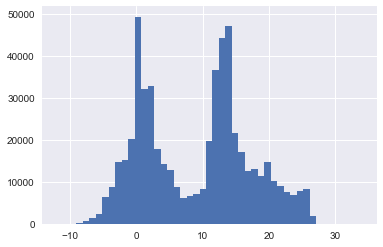

In [20]:
data['nutri-score'].hist(bins=int(data['nutri-score'].max() - data['nutri-score'].min() + 1))

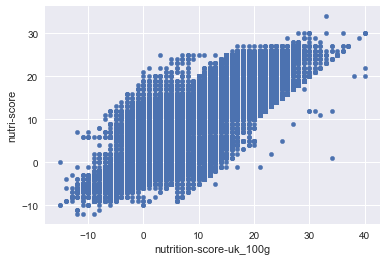

In [21]:
data.plot.scatter('nutrition-score-uk_100g', 'nutri-score')

Now we assign the letter corresponding to the nutri-score.

In [22]:
def nutri_score_letter(row):
    nutri_score = row['nutri-score']
    product_name = row['product_name']
    
    # check if nutri_score is nan
    if nutri_score != nutri_score:
        return np.nan
    
    if row['Category'] == 'Beverages':
        if nutri_score <= 1:
            return 'B'
        elif nutri_score <= 5:
            return 'C'
        elif nutri_score <= 9:
            return 'D'
        else:
            return 'E'
    else:
        if nutri_score <= -1:
            return 'A'
        elif nutri_score <= 2:
            return 'B'
        elif nutri_score <= 10:
            return 'C'
        elif nutri_score <= 18:
            return 'D'
        else:
            return 'E'

In [23]:
data['nutri-score_letter'] = data.apply(nutri_score_letter, axis=1)

### Analyse the nutri-score across the categories

In [24]:
# Count the letter occurences for each category
letter_counts_per_cat = data.groupby(['Category', 'nutri-score_letter']).count()[['nutri-score']]
letter_counts_per_cat

nutri-score
Category          nutri-score_letter             
Beverages         B                          5317
                  C                          4425
                  D                            84
                  E                          1760
Composite         A                          2249
                  B                          3343
                  C                          4271
                  D                          3705
                  E                            12
Dairies           A                          1051
                  B                          2742
                  C                          4305
                  D                          7547
                  E                           346
Fat Sauces        A                           374
                  B                           979
                  C                          1967
                  D                          3322
                  E                          3283
Fish Meat Eggs    A                          2804
                  B                           871
                  C                           981
                  D                          6909
                  E                            33
Fruits Vegetables A                          3474
                  B                          3273
                  C                          1544
                  D                           793
                  E                           144
Snacks            A                           196
                  B                           645
                  C                          1825
                  D                         14996
                  E                         14889
Starchy           A                          5012
                  B                          2921
                  C                          2205
                  D                          2440
                  E                           168
Unknown           A                         14199
                  B                         22690
                  C                         17243
                  D                         38819
                  E                         12484

In [25]:
# For some categories, some letters are not represented. We add the missing rows with 0 as value.
for cat in letter_counts_per_cat.index.levels[0]:
    for letter in letter_counts_per_cat.index.levels[1]:
        if (cat, letter) not in letter_counts_per_cat.index:
            letter_counts_per_cat.loc[(cat, letter), :] = 0
            
letter_counts_per_cat.sort_index(inplace=True)

In [26]:
# normalize the counts
totals = letter_counts_per_cat.reset_index()[['Category', 'nutri-score']].groupby('Category').sum()
score_distr_per_cat = letter_counts_per_cat / totals

In [27]:
# colors similar to the original nutri-score ones
nutri_score_colors = ['green', 'limegreen', 'gold', 'darkorange', 'orangered']

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


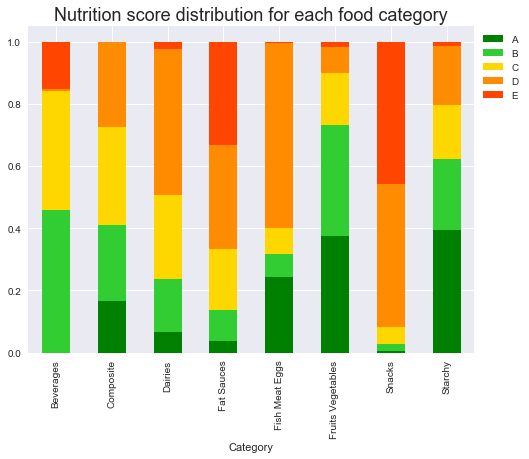

In [28]:
score_distr_per_cat.drop('Unknown').reset_index().pivot(index='Category', columns='nutri-score_letter', values='nutri-score').plot.bar(stacked=True, figsize=(8,6), colors=nutri_score_colors)
plt.legend(bbox_to_anchor=(1, 1.0))
plt.title('Nutrition score distribution for each food category', fontsize=18);

In [29]:
letter_counts_per_cat

nutri-score
Category          nutri-score_letter             
Beverages         A                           0.0
                  B                        5317.0
                  C                        4425.0
                  D                          84.0
                  E                        1760.0
Composite         A                        2249.0
                  B                        3343.0
                  C                        4271.0
                  D                        3705.0
                  E                          12.0
Dairies           A                        1051.0
                  B                        2742.0
                  C                        4305.0
                  D                        7547.0
                  E                         346.0
Fat Sauces        A                         374.0
                  B                         979.0
                  C                        1967.0
                  D                        3322.0
                  E                        3283.0
Fish Meat Eggs    A                        2804.0
                  B                         871.0
                  C                         981.0
                  D                        6909.0
                  E                          33.0
Fruits Vegetables A                        3474.0
                  B                        3273.0
                  C                        1544.0
                  D                         793.0
                  E                         144.0
Snacks            A                         196.0
                  B                         645.0
                  C                        1825.0
                  D                       14996.0
                  E                       14889.0
Starchy           A                        5012.0
                  B                        2921.0
                  C                        2205.0
                  D                        2440.0
                  E                         168.0
Unknown           A                       14199.0
                  B                       22690.0
                  C                       17243.0
                  D                       38819.0
                  E                       12484.0

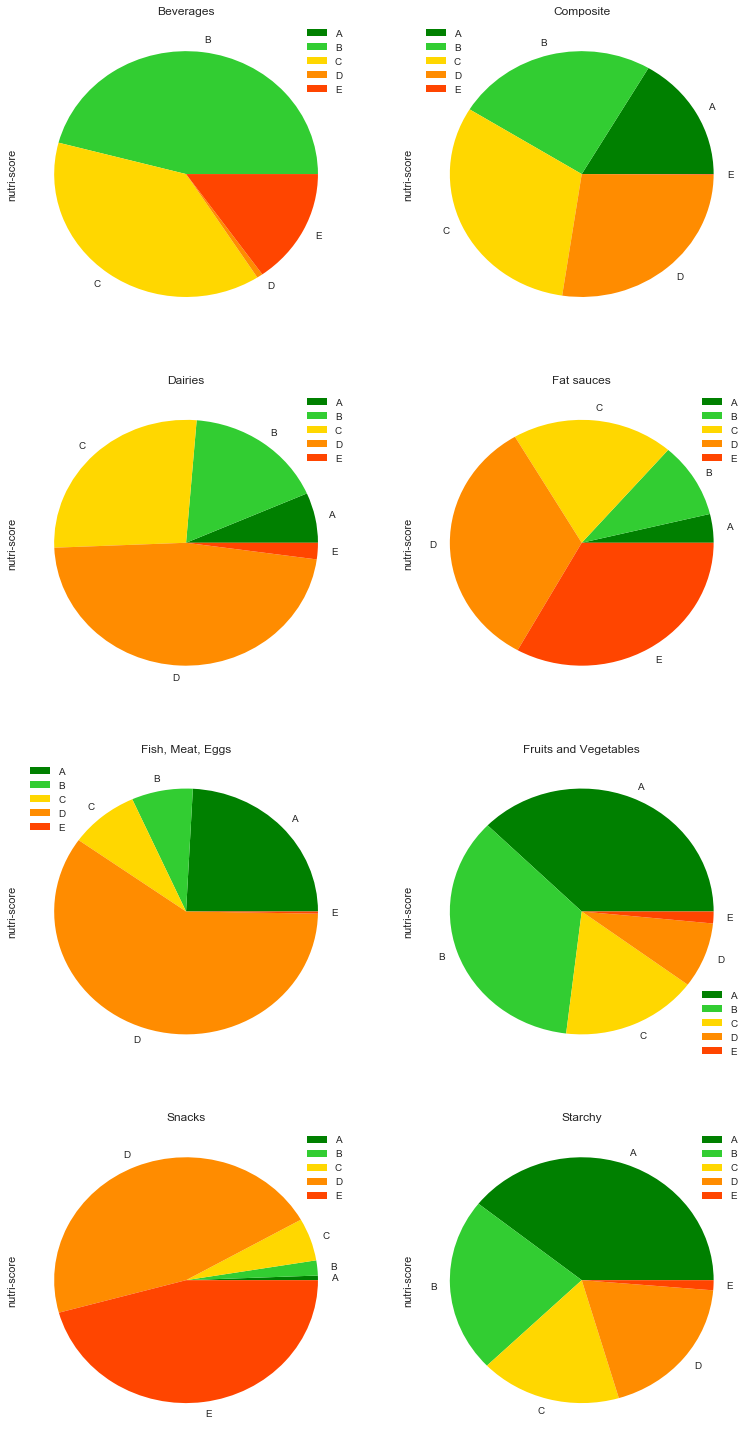

In [30]:
plt.figure(figsize=(13, 26))
letter_counts_per_cat.loc['Beverages'].plot.pie('nutri-score', ax=plt.subplot(421), title='Beverages', colors=nutri_score_colors)
letter_counts_per_cat.loc['Composite'].plot.pie('nutri-score', ax=plt.subplot(422), title='Composite', colors=nutri_score_colors)
letter_counts_per_cat.loc['Dairies'].plot.pie('nutri-score', ax=plt.subplot(423), title='Dairies', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fat Sauces'].plot.pie('nutri-score', ax=plt.subplot(424), title='Fat sauces', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fish Meat Eggs'].plot.pie('nutri-score', ax=plt.subplot(425), title='Fish, Meat, Eggs', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fruits Vegetables'].plot.pie('nutri-score', ax=plt.subplot(426), title='Fruits and Vegetables', colors=nutri_score_colors)
letter_counts_per_cat.loc['Snacks'].plot.pie('nutri-score', ax=plt.subplot(427), title='Snacks', colors=nutri_score_colors)
letter_counts_per_cat.loc['Starchy'].plot.pie('nutri-score', ax=plt.subplot(428), title='Starchy', colors=nutri_score_colors)

In [31]:
score_mean_by_category = data[['Category', 'nutri-score']].groupby('Category').mean()
score_mean_by_category

,nutri-score
Category,
Beverages,3.280511
Composite,4.931075
Dairies,8.300419
Fat Sauces,12.615013
Fish Meat Eggs,7.548370
Fruits Vegetables,1.669701
Snacks,17.427084
Starchy,2.972776
Unknown,8.478769


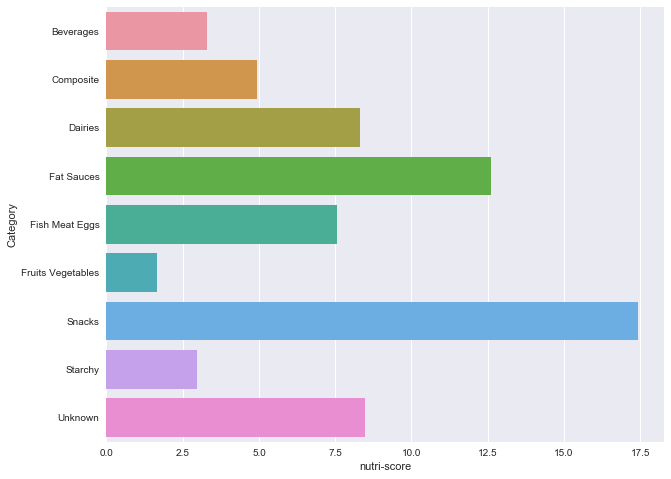

In [32]:
plt.figure(figsize=(10,8))
sns.barplot(score_mean_by_category['nutri-score'], score_mean_by_category.index,orient='h')

In [33]:
carbon_mean_by_category = data[['Category', 'carbon-footprint_100g']].groupby('Category').mean()

In [34]:
pd.concat((carbon_mean_by_category, score_mean_by_category), axis=1).corr()

,carbon-footprint_100g,nutri-score
carbon-footprint_100g,1.000000,0.210482
nutri-score,0.210482,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70a998b2b0>,
      dtype=object)

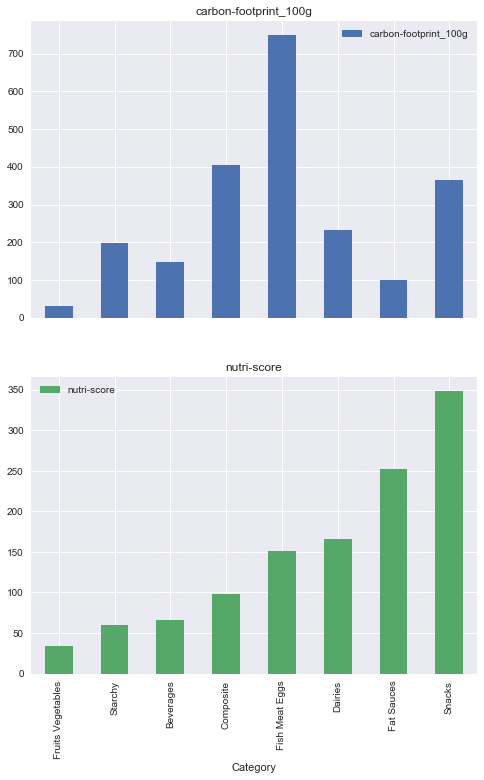

In [35]:
pd.concat((carbon_mean_by_category, 20*score_mean_by_category), axis=1).drop('Unknown').sort_values('nutri-score').plot.bar(subplots=True, figsize=(8, 12))

In [36]:
countries_en_scores = {}

In [37]:
def random_stuff(row):
    letter = row['nutri-score_letter']
    if letter == letter:
        for exportator in row['countries_en'].split(','):
            if exportator in countries_en_scores:
                countries_en_scores[exportator] += [row['nutri-score_letter']]
            else:
                countries_en_scores[exportator] = [row['nutri-score_letter']]

In [38]:
data[data['countries_en'].notna()].apply(random_stuff, axis=1);

In [39]:
threshold = 1

In [40]:
{country: Counter(countries_en_scores[country]) for country in countries_en_scores if len(countries_en_scores[country]) > threshold}

{'France': Counter({'D': 141022,
          'B': 73354,
          'C': 56350,
          'A': 38123,
          'E': 57106}),
 'United States': Counter({'D': 60224,
          'A': 26681,
          'C': 23917,
          'E': 18112,
          'B': 31413}),
 'Canada': Counter({'D': 355, 'A': 190, 'C': 240, 'E': 136, 'B': 240}),
 'Oman': Counter({'D': 1, 'A': 2, 'C': 2, 'B': 2, 'E': 1}),
 'Germany': Counter({'E': 1851, 'C': 1896, 'D': 3761, 'B': 2455, 'A': 1387}),
 'United Kingdom': Counter({'D': 1348,
          'A': 577,
          'E': 632,
          'B': 718,
          'C': 643}),
 'Mexico': Counter({'B': 673, 'D': 665, 'A': 387, 'C': 476, 'E': 315}),
 'Belgium': Counter({'E': 818, 'C': 895, 'A': 588, 'B': 1139, 'D': 1796}),
 'Netherlands': Counter({'E': 143, 'C': 125, 'B': 178, 'D': 297, 'A': 128}),
 'Australia': Counter({'E': 112, 'C': 171, 'D': 278, 'A': 122, 'B': 211}),
 'Switzerland': Counter({'E': 2169,
          'C': 2250,
          'A': 1883,
          'D': 3873,
          'B': 2632

In [41]:
origins_countries_pairs = []

for idx, row in data[['origins_tags', 'countries_en']].dropna().iterrows():
    origin_split = row['origins_tags'].split(',')
    countries_split = row['countries_en'].split(',')
    for orig in origin_split:
        for country in countries_split:
            origins_countries_pairs += [[idx, orig, country]]

origins_countries_pairs_np = np.array(origins_countries_pairs)

travel_data = pd.DataFrame(origins_countries_pairs_np[:,1:], index=origins_countries_pairs_np[:,0], columns=['origin', 'destination'])

In [42]:
data['origins_tags'].value_counts()

france                                                                                                                               11300
union-europeenne                                                                                                                      2042
mexico                                                                                                                                1549
italie                                                                                                                                 986
espagne                                                                                                                                904
espana                                                                                                                                 764
australia                                                                                                                              465
suisse                     

In [43]:
travel_data['destination'].value_counts()

France                   42446
Spain                     3172
Germany                   2470
Mexico                    2243
Switzerland               2088
Australia                 1358
United Kingdom            1186
Belgium                   1140
Italy                      607
United States              514
Canada                     441
Romania                    426
Sweden                     415
Portugal                   320
Brazil                     201
Réunion                    165
Netherlands                156
Austria                    149
Madagascar                 124
Guadeloupe                 112
Russia                     106
India                       98
Hungary                     90
French Polynesia            84
Denmark                     81
French Guiana               80
Ireland                     73
Tunisia                     70
Georgia                     66
New Zealand                 61
                         ...  
sq:kosovo                    1
Mauritan

In [44]:
travel_data['origin'].value_counts()

france                                                                       16408
union-europeenne                                                              2934
mexico                                                                        1582
italie                                                                        1472
espagne                                                                       1266
espana                                                                        1201
suisse                                                                         721
deutschland                                                                    604
australia                                                                      599
belgique                                                                       533
perou                                                                          419
neprecizata                                                                    404
alle

In [45]:
travel_data['destination'].value_counts()[:50]

France                       42446
Spain                         3172
Germany                       2470
Mexico                        2243
Switzerland                   2088
Australia                     1358
United Kingdom                1186
Belgium                       1140
Italy                          607
United States                  514
Canada                         441
Romania                        426
Sweden                         415
Portugal                       320
Brazil                         201
Réunion                        165
Netherlands                    156
Austria                        149
Madagascar                     124
Guadeloupe                     112
Russia                         106
India                           98
Hungary                         90
French Polynesia                84
Denmark                         81
French Guiana                   80
Ireland                         73
Tunisia                         70
Georgia             